In [1]:
import torch
import sim_data_gen
import numpy as np
import dr_crn
import matplotlib.pyplot as plt

In [2]:
n_feat = 5

In [3]:
def get_mmd(x_train):
    feat = x_train[:, :n_feat]
    causes = x_train[:, n_feat:]
    cause_ind = sim_data_gen.cause_to_num(causes)
    uniques, counts = np.unique(cause_ind, return_counts=True)
    uniques = uniques[counts > 1]
    mmd_sigma = 1
    mmd = 0
    for i in range(len(uniques)):
        x1 = torch.tensor(feat[cause_ind == uniques[i]])
        x2 = torch.tensor(feat[cause_ind != uniques[i]])
        mmd = mmd + torch.abs(dr_crn.mmd2_rbf(x1, x2, mmd_sigma))
    return mmd

In [4]:
scp_list = []
scp_list_sd = []

for k in [1,2,3,4,5]:
    k = k * 2
    config_key = 'ea_balance_{}'.format(k)

    model_id='SCP'
    seed_list = []
    for seed in [1, 2, 3, 4, 5]:

        x_train = torch.load('model/simulation_overlap/{}_{}_{}_x.pth'.format(config_key, model_id, seed))
        x_train = x_train.cpu().numpy()
        m = get_mmd(x_train)
        seed_list.append(m)
    
    seed_list = np.array(seed_list)
    m = seed_list.mean()
    sd = seed_list.std()
    scp_list.append(m)
    scp_list_sd.append(sd)

0.028936246
0.101032436
0.1943626
0.27979556
0.34191176


In [5]:
base_line_list = []
base_line_list_sd = []

for k in [1,2,3,4,5]:
    k = k * 2
    config_key = 'ea_balance_{}'.format(k)

    model_id='IPW'
    seed_list = []
    for seed in [1, 2, 3, 4, 5]:

        x_train = torch.load('model/simulation_overlap/{}_{}_{}_x.pth'.format(config_key, model_id, seed))
        x_train = x_train.cpu().numpy()
        causes = x_train[:, n_feat:]
        m = get_mmd(x_train)
        seed_list.append(m)
    
    seed_list = np.array(seed_list)
    m = seed_list.mean()
    sd = seed_list.std()

    base_line_list.append(m)
    base_line_list_sd.append(sd)

In [10]:
baseline = np.array(base_line_list)
scp = np.array(scp_list)

baseline_sd = np.array(base_line_list_sd)
scp_sd = np.array(scp_list_sd)

In [11]:
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '13'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

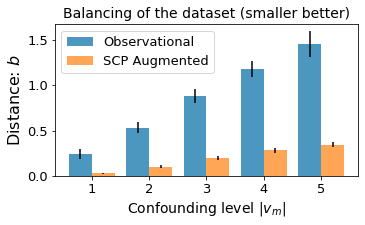

In [12]:
plt.figure(figsize=(5,3))
width = 0.4
plt.bar(np.arange(1,6)-0.2, baseline,yerr=base_line_list_sd, color=colors[0], width=width, alpha=0.7, label='Observational')
plt.bar(np.arange(1,6)+0.2, scp,yerr=scp_list_sd, color=colors[1], width=width, alpha=0.7, label = 'SCP Augmented')
plt.xlabel(r'Confounding level $|v_m|$', fontsize=14)    
plt.ylabel('Distance: $b$', fontsize=16)
plt.legend()
plt.title(r'Balancing of the dataset (smaller better)', fontsize=14)    
plt.tight_layout(pad=0.2)
plt.savefig(fname='Fig5_A.png', dpi=300)

In [16]:
import pandas as pds
from scipy.special import comb

In [17]:
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '13'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [18]:
df_base = pds.read_csv('results/results_ea_baseline.txt', sep=' ', header=None)

weights = np.array([comb(5, i) for i in range(1, 6)])
x_ref = np.sum(np.arange(1,6) * weights) / np.sum(weights)
y_ref = np.interp(x_ref, np.arange(1, 6), df_base[2].values)

x_ref_scp = 1 + 0.1 * (np.sum(np.arange(5))) / 5
x_ref_scp
y_ref_scp = np.interp(x_ref_scp, np.arange(1, 6), df_base[2].values)


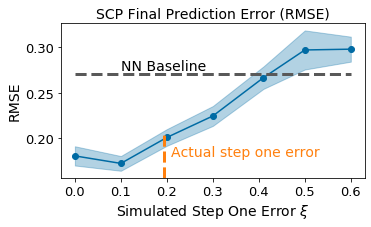

In [21]:
prefix=''

dat = pds.read_csv('results{}/results_ea.txt'.format(prefix), sep=' ', header=None)

dat[4] = dat[4] / np.sqrt(32)
dat[5] = dat[5] / np.sqrt(32)

dat = dat.sort_values(1)
dat.tail(10)
dat1 = dat[dat[0] == 'SCP']
dat2 = dat[dat[0] == 'FB']

z_ref_scp = np.interp(y_ref_scp, np.arange(7) / 10, dat1[4].values)


plt.figure(figsize=(5,3))

plt.fill_between(dat1[1], dat1[4] - 2 * dat1[5], dat1[4] + 2 * dat1[5], alpha=0.3, color=colors[0])
plt.plot(dat1[1], dat1[4], '-o', color=colors[0], label='SCP')


plt.plot([0, 0.6], [1.533/ np.sqrt(32), 1.533/ np.sqrt(32)], ls='--', c=colors[3], label='No Aug.',  linewidth=3)

plt.axvline(y_ref_scp, ymax=0.3, ls='--', c=colors[1],  linewidth=3)
plt.title(r'SCP Final Prediction Error (RMSE)', fontsize=14)    
plt.xlabel(r'Simulated Step One Error $\xi$', fontsize=14)    
plt.ylabel('RMSE', fontsize=14)    

plt.text(0.1, 0.275, 'NN Baseline', fontsize=14)
plt.text(0.21, 0.18, 'Actual step one error', fontsize=14, c=colors[1])

plt.tight_layout(pad=0.1)

plt.savefig(fname='Fig5_B.png', dpi=300)